In [1]:
%matplotlib inline

In [2]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
path = r"C:\Users\thomasaar\Documents\GitHub\Notebooks\EpEg"
path = os.path.join(path, "")

In [4]:
name = "plasmon peak mapping-color range18-19 - bin2.dm3"

In [5]:
s = hs.load(path + name)

### Let's take a look at the data:

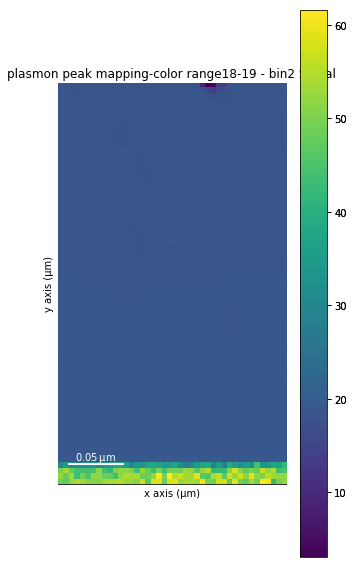

In [6]:
s.plot(cmap="viridis")

Note that there is a hole in the top-right of the image. In order to keep the color limits ok, I'm cropping out the top few pixels of the image.
Since the bottom apparently is substrate, I crop out that as well:

In [7]:
s = s.isig[:,5:-8]

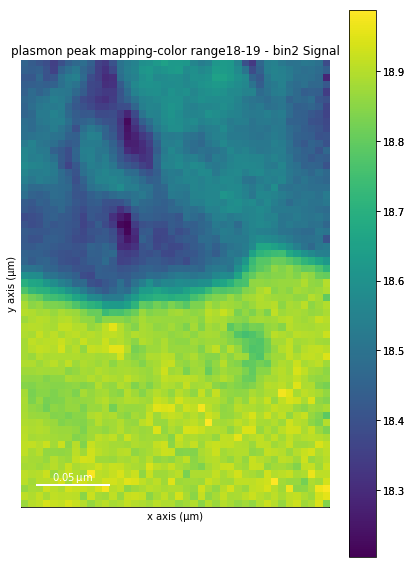

In [29]:
s.plot(cmap="viridis")

### To see, the Ep values in the top and bottom of the image are:

In [9]:
s.data

array([[ 18.45655441,  18.43328094,  18.41118813, ...,  18.51158905,
         18.49610138,  18.38674545],
       [ 18.44774437,  18.43819046,  18.445961  , ...,  18.49723434,
         18.47943497,  18.4413414 ],
       [ 18.42353439,  18.41949081,  18.46960068, ...,  18.48858261,
         18.47253418,  18.28552055],
       ..., 
       [ 18.86368752,  18.88583374,  18.88136673, ...,  18.88860703,
         18.96845818,  18.98303413],
       [ 18.90934372,  18.89379883,  18.91523361, ...,  18.8743515 ,
         18.93540573,  18.95536804],
       [ 18.87047958,  18.90478134,  18.91338921, ...,  18.89261246,
         18.94372177,  18.84222031]], dtype=float32)

### Settings constants for the relation Eg -> Ep

In [10]:
a = 129.25
b = 47.608
c = 4.47327
e = 3.38799
f = -1.40732
g = 0.513266

constants = a,b,c,e,f,g

In [11]:
def Eg_to_Ep(Eg, constants):
    import math
    
    a,b,c,e,f,g = constants
    return math.sqrt(Eg**2 + a**2*(2*b*g-c*f+math.sqrt(4*Eg*c**2*g-4*c**2*e*g+c**2*f**2))/(2*(b**2*g+c**2*e-b*c*f-Eg*c**2)))

### Duplicate signal, to change one later

In [12]:
Ep_signal = s
Eg_signal = s.deepcopy()

In [13]:
Ep = Eg_signal.data

### Find range of Ep values we need to convert to we need for a numerical solution:

In [14]:
print("Min", Ep.min())
print("Max", Ep.max())

Min 18.2035
Max 18.9881


In [27]:
Egvalues = np.arange(2.5,76,0.001) # 2.5 is the minimum Eg value, 76 seems to be the max - outside of this range the equation gives NaNs.
EgtoEpConversionArray = np.array([Eg_to_Ep(i, constants) for i in Egvalues])

### Let's see what our Eg -> Eg equation looks like:

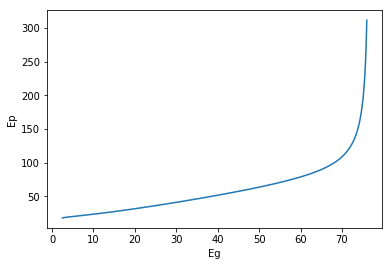

In [16]:
plt.plot(Egvalues,EgtoEpConversionArray,)
plt.xlabel("Eg")
plt.ylabel("Ep")

### Note that we are in the bottom left regime of this plot, and the relation is nearly linear, so it is more like this for us:

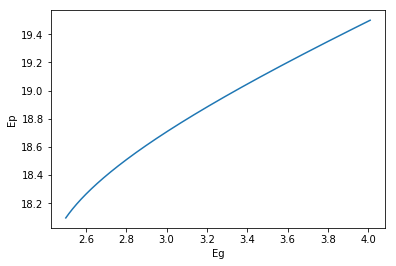

In [28]:
ourEgvalues = Egvalues[EgtoEpConversionArray < 19.5]
ourEpvalues = EgtoEpConversionArray[EgtoEpConversionArray < 19.5]
plt.plot(ourEgvalues,ourEpvalues,)
plt.xlabel("Eg")
plt.ylabel("Ep")
# I've just zoomed into the bottom left of the plot

In [18]:
np.diff(EgtoEpConversionArray).min() # Derivative is never negative, good - means that there can't be multiple values of Eg for a given Ep

0.00066359479534483512

### Let's find the first value in the Ep table equal to our pixel value, and use that index in the Eg table:

In [19]:
def func(Epvalue, Epvalues, EpEgConversionArray):
    import numpy as np
    Egvalue = Egvalues[np.where(EgtoEpConversionArray >= Epvalue)[0][0]]
    return Egvalue

In [20]:
print("These are the minimum and max Eg values found:")
print("Min", func(Ep_signal.data.min(), Egvalues, EgtoEpConversionArray))
print("Max", func(Ep_signal.data.max(), Egvalues, EgtoEpConversionArray))

These are the minimum and max Eg values found:
Min 2.561
Max 3.328


In [21]:
for x in np.nditer(Ep, op_flags=['readwrite']):
    x[...] = func(x, Egvalues, EgtoEpConversionArray)

In [23]:
Eg_signal.save(path + "Eg_values.tif")

Please answer y or n.


In [24]:
import scipy.io
scipy.io.savemat(path+"Eg.mat", mdict={'arr': Eg_signal.data})


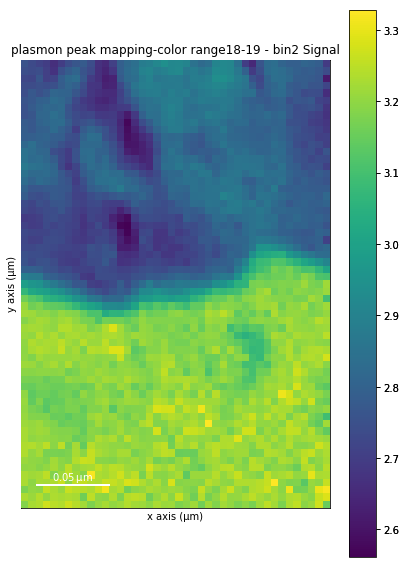

In [25]:
Eg_signal.plot(cmap="viridis")

### As we see below, the Eg values range from 2.7 in the top of the image, to varying around 38 in the bottom part of the image

In [30]:
Eg_signal.data

array([[  2.75300002,   2.73300004,   2.71399999, ...,   2.80299997,
          2.78900003,   2.69400001],
       [  2.74499989,   2.73699999,   2.74399996, ...,   2.78999996,
          2.77399993,   2.74000001],
       [  2.72399998,   2.72099996,   2.7650001 , ...,   2.78200006,
          2.76799989,   2.61599994],
       ..., 
       [ 38.43199921,  41.29800034,  36.35400009, ...,  42.55099869,
         32.33800125,  33.49200058],
       [ 40.56800079,  36.45600128,  41.21300125, ...,  40.91600037,
         40.32899857,  40.36700058],
       [ 36.80199814,  35.93099976,  40.4070015 , ...,  31.20299911,
         37.84500122,  39.59999847]], dtype=float32)